# Базовые модели финансовой математики

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Винеровский процесс

Снизу приведен алгоритм, который нам позволяет симулировать дискретизированные траектории процесса $(W_t)_{t \in \mathbb{R}_+}$. В отличие от гауссовских процессов мы можем использовать свойство независимости и гауссовости приращений и получить алгоритм, выдающий $N$ сечений процесса за $O(N)$.

In [3]:
def simulateWienerProcess(x0,ts,Ntraj):
    '''
    Simulates trajectories of Wiener process
    Input
    float x0 -- initial value
    float[] ts -- times
    int Ntraj -- number of trajectories to simulate
    Returns
    float[] of shape (Ntraj,xs.shape[0],len(ts))
    '''
    try:
        d=x0.shape[0]
    except:
        d=1

    xs=np.zeros([Ntraj,d,len(ts)])
    xs[...,0]=x0

    for kk in np.arange(1,len(ts)):
        noises=np.random.standard_normal(size=(Ntraj,d))#generate tensor Ntraj,d of independent standard normal random variables
        xs[...,kk] = xs[...,kk-1] + noises*np.sqrt(ts[kk]-ts[kk-1])

    return xs

In [4]:
a=0
b=100
Nt=500
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)

Ntraj=10
x0=0

wienTrajs = simulateWienerProcess(x0,ts,Ntraj)

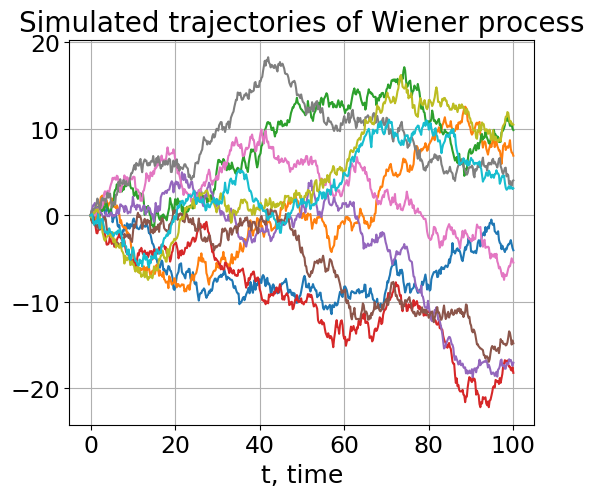

In [5]:
f, ax = plt.subplots(figsize=(6,5))

ax.grid()
ax.set_title('Simulated trajectories of Wiener process',fontsize=20)
ax.set_xlabel('t, time',fontsize=18)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)
ax.plot(ts,wienTrajs[:,0,:].T)

In [6]:
#2D
a=0
b=500
Nt=1000
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)

Ntraj=10
x0=np.zeros([100])

wienTrajs = simulateWienerProcess(x0,ts,Ntraj)

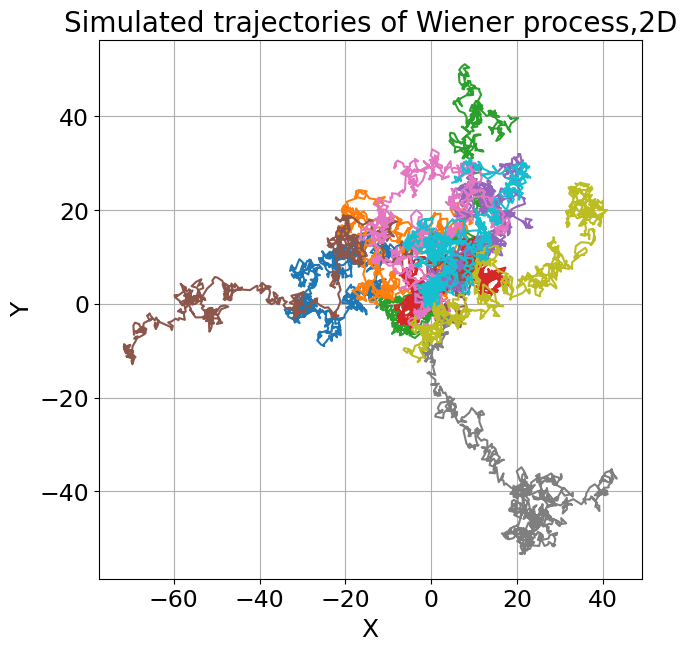

In [7]:
f, ax = plt.subplots(figsize=(7,7))

ax.grid()
ax.set_title('Simulated trajectories of Wiener process,2D',fontsize=20)
ax.set_xlabel('X',fontsize=18)
ax.set_ylabel('Y',fontsize=18)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)
ax.plot(wienTrajs[:,0,:].T,wienTrajs[:,1,:].T)

Винеровский процесс в размерности 1 и 2 рекуррентен. Если зафиксировать какое-нибудь открытое множество и начать оттуда траекторию, то траектория почти наверное его посетит ещё раз через конечное время. В размерности 3 и выше Винеровский процесс не обладает свойством рекуррентности (попробуйте поменять размерность в параметрах).

Процесс норм $B_t = \Vert W_t \Vert_2$ называют процессом Бесселя.

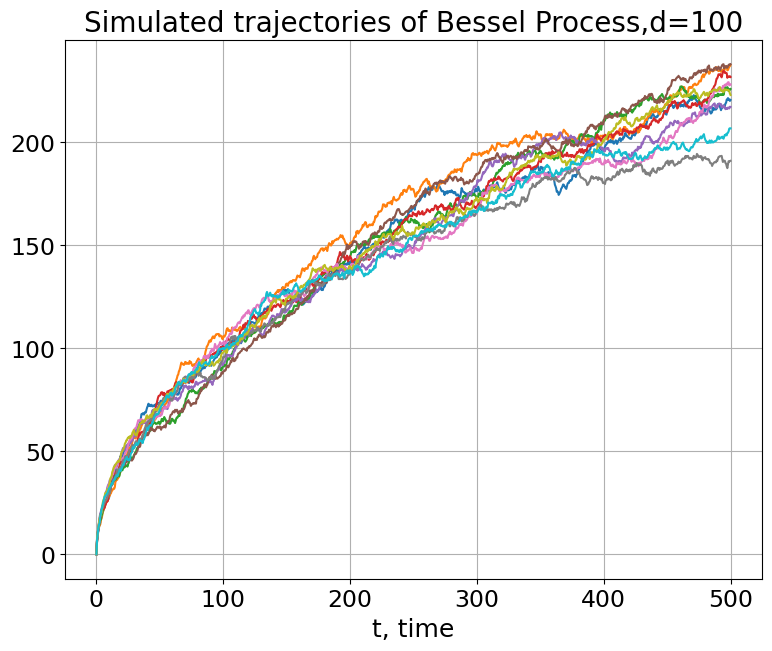

In [8]:
f, ax = plt.subplots(figsize=(9,7))

ax.grid()
ax.set_title(f'Simulated trajectories of Bessel Process,d={x0.shape[0]}',fontsize=20)
ax.set_xlabel('t, time',fontsize=18)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)
ax.plot(ts,np.linalg.norm(wienTrajs,ord=2,axis=1).T)

## Геометрическое Броуновское движение

Согласно модели Самуэльсона (её ещё называют моделью Блека-Шоулса), на эффективном рынке динамика цен задаётся геометрическим Броуновским движением, в одномерном случае

$$
X_t = x_0 e^{(\mu-\sigma^2/2)t + \sigma W_t}.
$$

Для того, чтобы сгенерировать траектории мы можем использовать уже реализованную выше модель Винеровского процесса.

In [9]:
def simulateGBM(x0,mu,sigma,ts,Ntraj):
        '''
        Simulates trajectories of GBM with parameters mu and sigma
        Input
        float[] x0 -- initial price, (d,)
        float[] mu -- mu parameter, (d,)
        float[] sigma -- sigma parameter, (d,)
        float[] ts -- times
        int Ntraj -- number of trajectories to simulate
        Returns
        float[] of shape (Ntraj,d,len(ts)) , trajectories
        '''
        try:
                wienProcs = simulateWienerProcess(np.zeros(x0.shape),ts-ts[0],Ntraj)
        except:
                wienProcs = simulateWienerProcess(0,ts-ts[0],Ntraj)

        xs = x0[None,:,None]*np.exp( (mu-sigma**2/2)[None,:,None]*ts[None,None,:] + sigma[None,:,None]*wienProcs)

        return xs

In [10]:
a=0
b=2
Nt=1000
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)

mu=0.05 * np.ones([1])
sigma=0.2 * np.ones([1])
Ntraj=20
x0=5 * np.ones([1])

gbmTrajs = simulateGBM(x0,mu,sigma,ts,Ntraj)
wienTrajs = simulateWienerProcess(x0,ts,Ntraj)

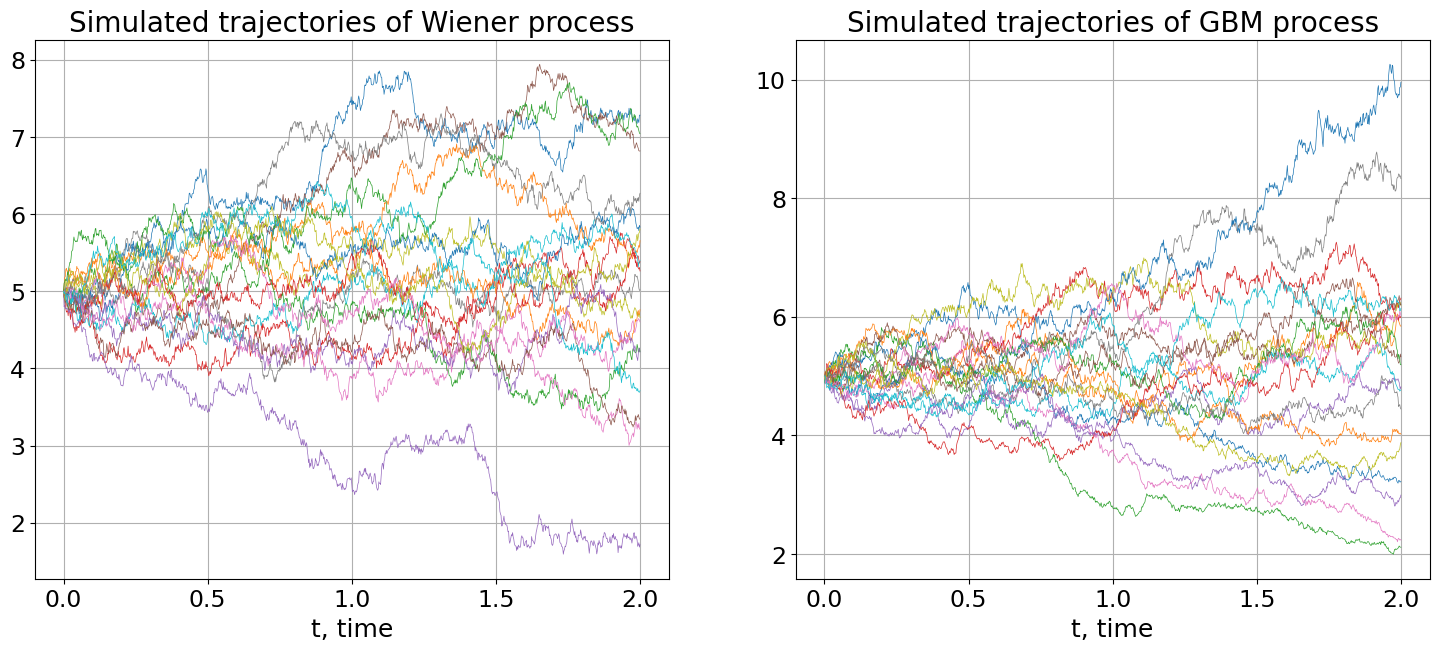

In [11]:
#plots

f, (ax1,ax2) = plt.subplots(1,2,figsize=(18,7))

ax1.grid()
ax1.set_title('Simulated trajectories of Wiener process',fontsize=20)
ax1.set_xlabel('t, time',fontsize=18)
ax1.tick_params(axis='x', labelsize=17)
ax1.tick_params(axis='y', labelsize=17)
ax1.plot(ts,wienTrajs[:,0,:].T, linewidth = 0.5)

ax2.grid()
ax2.set_title('Simulated trajectories of GBM process',fontsize=20)
ax2.set_xlabel('t, time',fontsize=18)
ax2.tick_params(axis='x', labelsize=17)
ax2.tick_params(axis='y', labelsize=17)
ax2.plot(ts,gbmTrajs[:,0,:].T, linewidth=0.5)

## Оценка опционов с помощью геометрического Броуновского движения

Европейские опционы в модели Блека-Шоулса можно оценивать спомощью известной формулы Блека-Шоулса. Такой приём, однако, не работает в случае, когда опцион продаётся на корзину активов, а не на один актив. Здесь помогают методы Монте-Карло.

Пусть на рынке есть $d$ активов. Напомним, что честная цена опциона с выплатой $f: \mathbb{R}^d \to \mathbb{R}$ и моментом исполнения $T>0$ есть

$$
\mathbb{E}\left\lbrace e^{-rT}f(X_T)\right\rbrace.
$$

Например, мы имеем (как минимум) по 1 единице каждого из активов, тогда классический европейский put-опцион будет иметь выплату

$$
f(x) = (K-x)_+,
$$

где $K$ -- страйк, а знак плюса озаначает, что выражение равно нулю, если $K-x<0$.

In [12]:
def priceEuropeanCall(x0,mu,sigma,f,T, NSamples=10):
    '''
    Sets a price on european put-option
    Input
    float[] x0 -- current prices, (d,)
    float[] mu -- mu parameter, (d,)
    float[] sigma -- sigma parameter, (d,)
    functionHandler f -- payment function, R^d --> R
    float T -- expiration time
    int NSamples -- number of Monte Carlo samples to use
    '''

    xs = simulateGBM(x0, mu, sigma, np.array([0,T]), NSamples)

    payments = f(xs[:,:,-1])
    priceMean = np.mean(payments)
    priceStd = np.std(payments)

    return priceMean,priceStd

In [13]:
#example above
mu=0.05 * np.ones([10])
sigma=0.2 * np.ones([10])
x0=15 * np.ones([10])
NSamples=10000
K=15
T=3

def paym(x):
    try:
        priceSum = np.mean(x, axis=1)
    except:
        priceSum = np.mean(x)

    return (priceSum-K)*((priceSum-K)>0)

priceMean, priceStd = priceEuropeanCall(x0,mu,sigma,paym,T,NSamples)
print(priceMean, "+-", 1.96*priceStd/np.sqrt(NSamples) )


2.486452444469326 +- 0.035956793650182936


In [14]:
#convergence of MC
d=10
experiments = [ {"mu":0.01*np.ones([d]), "sigma":0.08*np.ones([d]), "x0":5*np.ones([d]), "NSamples": nS, "K":5, "T": 100, "f":paym} \
                for nS in np.arange(100,100000,100)]

results = [ priceEuropeanCall(experiments[k]["x0"],experiments[k]["mu"],experiments[k]["sigma"],experiments[k]["f"],\
                              experiments[k]["T"], experiments[k]["NSamples"]) for k in np.arange(len(experiments))]

prices= np.array([results[k][0] for k in np.arange(len(results))])
priceStds= np.array([results[k][0] for k in np.arange(len(results))])
NSampless = np.arange(100,100000,100)

In [15]:
print(prices)

[1.10029347 1.00554165 1.23765444 0.99717984 0.93669373 0.85410513
 1.23308207 1.10015753 1.04824028 1.0858706  0.99561297 1.12916543
 1.08212128 1.04630732 1.04839579 1.06696684 0.92816628 1.03049848
 1.08693817 1.09496191 1.08093509 0.98367088 1.0375044  1.07153387
 0.97910106 1.07181725 1.08576213 0.97363172 1.04188862 1.01932406
 1.09720422 1.0775375  1.00439159 1.09357827 1.06509616 1.12026578
 1.06860703 1.0077318  1.05608674 0.998965   1.00024579 1.05175934
 1.03481789 1.06416062 1.0982854  1.07887263 1.02191173 1.05780335
 1.02086073 1.06759424 1.0606985  1.02863091 0.99429521 1.06532856
 1.05310826 1.03511986 1.03009759 1.07536194 1.07293517 1.04057099
 1.06268819 1.034053   1.07248137 1.07842734 1.05403746 1.03421864
 1.05731821 1.0134624  1.0515516  1.05941406 1.04091424 0.9971404
 1.0231699  0.99202295 1.03228557 1.00249094 1.02376201 1.04540045
 1.0260199  1.01212783 1.03266773 1.06854614 1.04170806 1.03915892
 1.04065675 1.02919553 1.03686335 1.06775429 1.01440938 1.04765

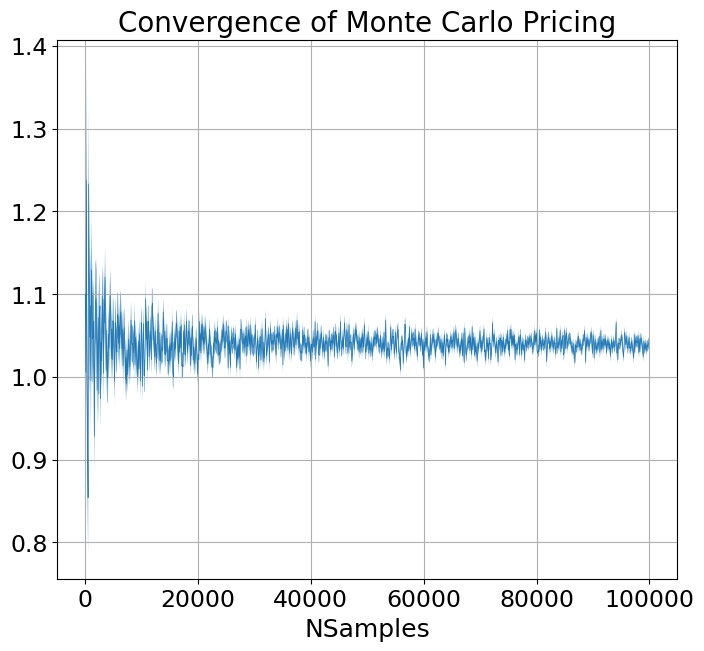

In [16]:
f, ax = plt.subplots(figsize=(8,7))

ax.grid()
ax.set_title('Convergence of Monte Carlo Pricing',fontsize=20)
ax.set_xlabel('NSamples',fontsize=18)
ax.tick_params(axis='x', labelsize=17)
ax.tick_params(axis='y', labelsize=17)
ax.plot(NSampless , prices, linewidth=0.5)
ax.fill_between(NSampless, prices + 1.96*priceStds/np.sqrt(NSampless),prices - 1.96*priceStds/np.sqrt(NSampless),alpha=0.7)

#ax.set_ylim([120,140])
